# Inflar la data de Seattle e importar herramientas🎈

1.Implementar el algoritmo “reservoir sampling” en Python. 2.Obtener una muestra de la base de datos: “librería Seattle” (Ustedes deciden el número de instancias de la muestra). 3.Analizar la muestra y obtener conclusiones al respecto.

In [ ]:
#Importamos muchas cosas diría lady Wooo
import pandas as pd
import numpy as np
import random
import csv
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [ ]:
#Este paso es el más importante, usamos DASK para no consumir RAM y hacerlo rápido
!python -m pip install "dask[complete]"
import dask
import dask.dataframe as dd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 837 kB 4.2 MB/s 
     |████████████████████████████████| 141 kB 49.5 MB/s 
     |████████████████████████████████| 830 kB 39.6 MB/s 
     |████████████████████████████████| 822 kB 31.5 MB/s 
     |████████████████████████████████| 802 kB 28.3 MB/s 
     |████████████████████████████████| 802 kB 43.5 MB/s 
     |████████████████████████████████| 793 kB 44.5 MB/s 
     |████████████████████████████████| 793 kB 32.9 MB/s 
     |████████████████████████████████| 791 kB 42.8 MB/s 
     |████████████████████████████████| 786 kB 43.4 MB/s 
     |████████████████████████████████| 779 kB 14.0 MB/s 
     |████████████████████████████████| 778 kB 17.1 MB/s 
     |████████████████████████████████| 776 kB 46.3 MB/s 
     |████████████████████████████████| 769 kB 42.9 MB/s 
     |████████████████████████████████| 766 kB 44.4 MB/s 
     |██████████████████████████

In [ ]:
#Conecto mi DRIVE donde ya está el comprimido checkouts_seattle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!unzip drive/MyDrive/checkouts_seattle.zip

Archive:  drive/MyDrive/checkouts_seattle.zip
  inflating: Checkouts by Title FAQs.pdf  
  inflating: checkouts-by-title.csv  
  inflating: socrata_metadata.json   
CPU times: user 670 ms, sys: 93 ms, total: 763 ms
Wall time: 1min 34s


# Dimensionar CSV,num líneas y tamaño 😎

In [ ]:
#Ahora debemos dimensionar el mounstruo
#¿Cuántas líneas tenemos en este caso?
%%time
!wc -l checkouts-by-title.csv

34892624 checkouts-by-title.csv
CPU times: user 245 ms, sys: 54.2 ms, total: 299 ms
Wall time: 38.3 s


Vemos que el CSV de Seattle tiene 7.13GB de tamaño y 35 millones de líneas (34,892,624). Por tanto, podríamos tener un muestreo k de 350,000 por ejemplo.

## Uso DASK para eficiencia y rapidez 👀

In [ ]:
#--DASK es super bueno para este tipo de trabajos porque:
# Dask, a flexible parallel computing library for Python. 
# Among many other features, Dask provides an API that emulates Pandas, 
# while implementing chunking and parallelization transparently.
start = time.time()
dask_df = dd.read_csv('/content/checkouts-by-title.csv')
end = time.time()
print("Tiempo de lectura del BIG CSV: ",(end-start),"sec")

Tiempo de lectura del BIG CSV:  0.28592729568481445 sec


In [ ]:
# revisemos que el tamaño del dataframe sea de 34M de líneas
# para estar seguros de que el CSV está en el DF
%%time
numtotal = len(dask_df)
print(numtotal)

34892623
CPU times: user 3min 23s, sys: 11.2 s, total: 3min 35s
Wall time: 3min 3s


In [ ]:
#Vemos que tipo de datos tiene el DF de DASK
%%time
dask_df.dtypes

CPU times: user 430 µs, sys: 0 ns, total: 430 µs
Wall time: 440 µs


UsageClass         object
CheckoutType       object
MaterialType       object
CheckoutYear        int64
CheckoutMonth       int64
Checkouts           int64
Title              object
Creator            object
Subjects           object
Publisher          object
PublicationYear    object
dtype: object

In [ ]:
#Sacamos una muestra de ~1M ~2.9% del total y lo pasamos a un DF de pandas
%%time
df = dask_df.sample(frac=0.029, replace=False, random_state=1).compute()

CPU times: user 3min 29s, sys: 10.2 s, total: 3min 39s
Wall time: 2min 54s


In [ ]:
#En este df haré el reservoir sampling de unos 350,000
len(df)

1011883

# Reservoir Sampling ⛴

In [ ]:
# Importamos las herramientas necesarias para el algoritmo
from itertools import islice
from random import randrange
from typing import Iterable

In [ ]:
# Definimos el algoritmo sin optimización según lo que dice internet
def random_subset( iterator, K ):
    result = []
    N = 0

    for item in iterator:
        N += 1
        if len( result ) < K:
            result.append( item )
        else:
            s = int(random.random() * N)
            if s < K:
                result[ s ] = item

    return result

¡Mucho ojo! interatordf = df

In [ ]:
#change pandas to numpy
%%time
interatordf = df.to_numpy()

CPU times: user 496 ms, sys: 129 ms, total: 625 ms
Wall time: 992 ms


In [ ]:
#Ejecuto la función con k y el df en pandas
%%time
k=350000
reservoir = pd.DataFrame(random_subset(interatordf,k))

CPU times: user 3.1 s, sys: 47.5 ms, total: 3.14 s
Wall time: 3.17 s


In [ ]:
#Revisamos que la reserva sea del tamaño k
len(reservoir)

350000

In [ ]:
#Incluimos los nombres de las columnas
reservoir.columns=['UsageClass','CheckOut_Type','Material_Type', 'CheckOut_Year','CheckOut_Month','CheckOuts','Title','Creator','Subjects','Publisher','Publication_Year']

# Ya tenemos todo, ahora a plotear un poquito para sacar conclusiones ⚙

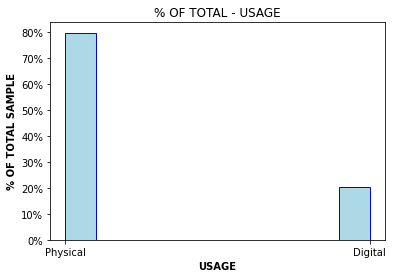

In [ ]:
data=reservoir['UsageClass']
plt.hist(data, weights=np.ones(len(data)) / len(data),color = "lightblue", ec="blue")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("USAGE", fontweight='bold')
plt.ylabel("% OF TOTAL SAMPLE", fontweight='bold')
plt.title("% OF TOTAL - USAGE")
plt.show()

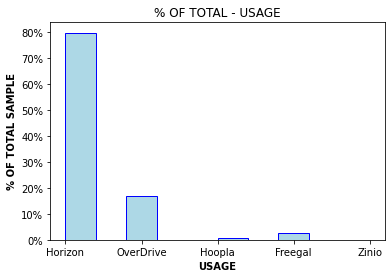

In [ ]:
data=reservoir['CheckOut_Type']
plt.hist(data, weights=np.ones(len(data)) / len(data),color = "lightblue", ec="blue")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("USAGE", fontweight='bold')
plt.ylabel("% OF TOTAL SAMPLE", fontweight='bold')
plt.title("% OF TOTAL - USAGE")
plt.show()

In [ ]:
#Vemos cuáles han sido los tipos de materiales que más han tenido checkouts top 10
tablas = reservoir.groupby("CheckOut_Year").agg(LosChecksOuts=pd.NamedAgg(column="CheckOuts", aggfunc="sum"))
tablassorted = tablas.sort_values(by='LosChecksOuts', ascending=False)

In [ ]:
tablassorted.head(10)

,LosChecksOuts
CheckOut_Year,
2014,95365
2013,92838
2018,90410
2015,89974
2010,87580
2009,87415
2017,87183
2011,86941
2016,86721


In [ ]:
#Vemos cuáles han sido los años más han tenido checkouts top 10
tablas = reservoir.groupby("Material_Type").agg(LosChecksOuts=pd.NamedAgg(column="CheckOuts", aggfunc="sum"))
tablassorted = tablas.sort_values(by='LosChecksOuts', ascending=False)

In [ ]:
tablassorted.head(10)

,LosChecksOuts
Material_Type,
BOOK,580504
VIDEODISC,295231
SOUNDDISC,143309
EBOOK,107741
AUDIOBOOK,48759
VIDEOCASS,15243
SONG,12294
MUSIC,3559
SOUNDCASS,3438
